# Current-Based Spiking Neural Network (current-SNN)

Spike-coding network a network of N neurons based on the paper by Barret et al. (2016). Full citation:

Barrett, D. G., Deneve, S., & Machens, C. K. (2016). Optimal compensation for neuron loss. Elife, 5, e12454.

## Install required packages

Install required packages

In [1]:
import numpy as np
import pylab as pl
import math
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d
import random
import os
import matplotlib.animation as animation
import copy

## Functions used for simulation

### Initialize weights

Initialize weights

In [2]:
def initialize_weights(N, d):
    """ Initialize decoding weights of the different neurons. 
    
    Parameters
    ----------
    N : int
        number of neurons
    d : int
        number of dimensions
    
    Returns
    ----------
    D : 1D-array
        weights per dimension, size (N, d)
    
    """

    if d == 2:
        # 2-dimensional input signal
        
        weights = np.linspace(0, 2 * np.pi, N + 1)       
        D = np.zeros((N,d))
        D[:, 0] = [np.sin(weight) for weight in weights[0:N]]
        D[:, 1] = [np.cos(weight) for weight in weights[0:N]]
        
    else:
        D = np.random.normal(0, 0.4, size=(N, d))
        
    D = np.asarray(D).reshape((N, d))
               
    return D

### Initialize parameters

Initialize parameters

In [3]:
def initialize_params(N, d, dt, iterations, D, beta):
    """ Initialize variables and parameters. 
    
    Parameters
    ----------
    N : int
        number of neurons
    d : int
        number of dimensions
    dt : int
        time step
    iterations : int
        length of the simulation
    D : 1D-array
        weights per dimension, size (N, d)
    beta : int
        cost
        
    Returns
    ----------
    t : 1D-array
        timesteps
    voltage : array
        voltages, size (N, iterations) 
    x_est : 1D-array
        input estimate per timestep, size (d, iterations)
    o : array
        spike trains, with value 0 if there is no spike and value 1/dt if there is a spike,
        size (N, iterations) 
    T : 1D-array
        threshold of the neurons
    
    """
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # voltage
    voltage = np.zeros((N, iterations))

    # input estimate
    x_est = np.ones((d, iterations)) * 0

    # spike train
    o = np.zeros((N, iterations))

    # threshold
    T = [(np.dot(weight, weight) + beta)/2 for weight in D]

    return (t, voltage, x_est, o, T)

### Time varying signal

Create time varying signal

In [4]:
def time_varying_signal(d, positive_signal=False):
    """ Initialize time varying, sinusoidal input signal. 

    Parameters:
    d: int
        number of dimensions
    positive: boolean, optional
        positive input signal only (True) or not (False)
    
    Returns
    ----------
    x : array
        input per timestep, size (d, iterations)
    c : array
        sum of the input and input derivative per timestep, size (d, iterations)
        
    """
    
    c = []
    x = []
    
    # number of sinus periods (total # of sinus periods = 2 * cycles)
    cycles = 2
    t = np.linspace(0, np.pi, d + 1)       # starting points of d-dimensioan sinusoidal input signals
    
    for i in range(d):
        
        # create input signal
        x_temp = []
        if positive_signal == True:
            x_temp = np.sin(2 * np.linspace(-cycles * np.pi, cycles * np.pi, iterations) + t[i]) + 2
        else:
            x_temp = np.sin(2 * np.linspace(-cycles * np.pi, cycles * np.pi, iterations) + t[i])
        
        # compute derivative
        dxdt = np.diff(x_temp)/dt
        c_temp = x_temp[:-1] + dxdt

        c.extend(c_temp)
        x.extend(x_temp)

    c = np.asarray(c).reshape((d, iterations - 1))
    x = np.asarray(x).reshape((d, iterations))

    return(x, c)

In [5]:
def time_varying_signal_plateau(c_upp=[1, 1], constant=False):
    """ Initialize time varying input signal with a plateau. 
    
    Parameters
    ----------
    c_upp : int, optional
        value of the plateau
    constant : boolean, optional
        create a constant, time-invariant (True) or a constant (False) input signal
    
    Returns
    ----------
    x : array
        input per timestep, size (d, iterations)
    c : array
        sum of the input and input derivative per timestep, size (d, iterations)
        
    """
        
    c = []
    x = []
    
    if constant == True:
        # creates constant input signal
        x_t = np.ones((d, iterations))
        for i in range(d):
             x_t[i, :] *= c_upp[i]

        c = np.asarray(x_t).reshape((d, iterations))
        x = np.asarray(x_t).reshape((d, iterations))
    
    else:
        # creates time-variant input signal
        x_t = np.ones((d, iterations))
        for i in range(d):
             x_t[i, :] *= c_upp[i]
        step = int(np.round(iterations * 0.1))
        x_t[:, 0:2 * step] = 0
        x_t[:, iterations - 2 * step:iterations] = 0

        # smooth signal
        x = gaussian_filter1d(x_t, sigma=20)
        
        # compute derivative
        for i in range(d):
            dxdt = np.diff(x[i,:])/dt
            c.extend(x[i, :-1] + dxdt)

        c = np.asarray(c).reshape((d, iterations - 1))
        x = np.asarray(x).reshape((d, iterations))
        
    return (x, c)

### Run simulation

In [6]:
def run(tau, beta):
    """ Run simulation of spike coding network. At each time step, the voltage and input estimate is computed
    using the Euler's method. The network follows a spike rule that if one of the voltage reaches threshold the
    network outputs a spike wherafter the voltages and input estimate are updated. 
    
    Parameters
    ----------
    
    tau : int
        time constant
    beta : int
        cost
    
    """
    
    for t in range(1, iterations):

        # update input estimate
        dxestdt = (-1/tau) * x_est[:, t - 1] + np.dot(D.T, o[:, t - 1])
        x_est[:, t] = x_est[:, t - 1] + dt * dxestdt

        # update voltages
        dVdt = (-1/tau) * voltage[:, t - 1] + np.dot(D, c[:,t - 1]) - np.dot(np.dot(D, D.T) + np.identity(N) * beta, o[:, t - 1])
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        neurons = np.arange(0, N, 1)
        above_threshold = neurons[np.where(voltage[:, t] > T)]

        # reset neurons' voltages when threshold is exceeded
        if len(above_threshold) > 0:

            # select spiking neuron
            spike_neuron = np.random.choice(above_threshold)
            
            # update spikes
            o[spike_neuron, t] = 1/dt

## Functions to visualize data

### Decoding weights

In [7]:
def plot_weights():
    """ Plot the weights for N neurons (2D and 3D input signal). """
    
    # plot weights for (d=)2 or (d=)3 dimensional-input
    if d == 2:
        plots = 2
        pl.subplots(plots, 1, figsize=(15, 15)) # figsize=(12, 4)
        pl.axhline(y=0, color='k', alpha=0.6)
        pl.axvline(x=0, color='k', alpha=0.6)
   
        for n in range(2):
            pl.subplot(1, 2, n+1)
            if n==0:
                for i in range(N):
                    pl.arrow(0, 0, D[i, 0], D[i, 1], color=color[i], length_includes_head=True, head_width=0.02)
            else:
                for i in range(N):
                    pl.scatter(D[i][0], D[i][1], color=color[i], label='N%i' %(i+1))
            pl.axis('square')    
            pl.xlabel('D1')
            pl.ylabel('D2')
            pl.xlim(min(D[:, 0]) - 0.1, max(D[:, 0]) + 0.1)
            pl.ylim(min(D[:, 1]) - 0.1, max(D[:, 1]) + 0.1)

    elif d == 3:
        fig = pl.figure()
        ax = pl.axes(projection='3d')
        
        # plot weights as points
        for i in range(N):
            ax.scatter3D(D[i][0], D[i][1], D[i][2], color=color[i], s=50, label='N%i' %(i+1))
        ax.set_xlabel('D1')
        ax.set_ylabel('D2')
        ax.set_zlabel('D3')
    else:
        print("No plot generated: function for 2D and 3D signal input only. ")

### Bounding Box

In [75]:
def plot_bounding_box():
    """ Plot bounding box. 
        
    Returns
    ----------
    fig : plot
        figure with the bounding box
    
    """
    
    fig = pl.figure(figsize=(15, 15))
    pl.axis('square')
    pl.axis('off')
    pl.axhline(y=0, color='k')
    pl.axvline(x=0, color='k')
    val_min = -0.5
    val_max = c_upp[0]
    val_min2 = 1
    val_max2 = 3
    pl.xlim(val_min2, val_max2)
    pl.ylim(val_min2, val_max2)
    w = 6
    
    for i in range(N):
        if D[i, 0] != 0 and D[i, 1] != 0:
            x1 = np.zeros(2)
            x2 = np.linspace(-10, 10, 2)
            for j in range(2):
                x1[j] = (D[i, 1] * (c_upp[1] - x2[j]) + D[i, 0] * c_upp[0] - T[i])/ D[i, 0]
            pl.plot(x1, x2, color=color[i, :], lw=w)
        elif D[i, 0] == 0:
            x1 = np.linspace(-10, 10, 2)
            x2 = np.zeros(2)
            for j in range(2):
                x2[j] = (D[i, 1] * c_upp[1] - T[i])/ D[i, 1]
            pl.plot(x1, x2, color=color[i, :], lw=w)
        if D[i, 1] == 0:
            x1 = np.zeros(2)
            x2 = np.linspace(-10, 10, 2)
            for j in range(2):
                x1[j] = (D[i, 0] * c_upp[0] - T[i])/ D[i, 0]
            pl.plot(x1, x2, color=color[i, :], lw=w)
    
    return fig

In [77]:
def plot_error_space(plot_error=False, plot_true_signal=False, start=0):
    """ Plots 2D/3D error space with the bounding box. 
    
    Parameters
    ----------
    plot_error : boolean, optional
        plot error at every timestep (True) or not (False)
    plot_true_signal: boolean, optional
        plots input signal (True) or not (False)
    start : int, optional
        plots error from this timepoint onwards
        
    """

    # enable LaTeX
    pl.rc('text', usetex=True)
    
    if d == 2:
        # 2-dimensional input signal
        
        fig = plot_bounding_box()
        if plot_error == True:
            pl.plot(x_est[0, start:iterations], x_est[1, start:iterations], color='gray')
        if plot_true_signal == True:
            pl.plot(c_upp[0], c_upp[1], 'ko', markersize=15)
            
    elif d == 3:
        # 3-dimensional input signal
        plots = d
        counter = 0
        idx1 = [0, 1, 2]
        idx2 = [1, 2, 0]
        idx3 = [2, 0, 1]
        
        for i in range(plots):
                counter = counter + 1
                fig = plot_bounding_box(idx1[i] + 1, idx2[i] + 1, idx3[i] + 1)
                pl.xlabel('$x_{%i} - \hat{x}_{%i}$' %(idx1[i] + 1, idx1[i] + 1), fontsize=20)
                pl.ylabel('$x_{%i} - \hat{x}_{%i}$' %(idx2[i] + 1, idx2[i] + 1), fontsize=20)
                pl.xlim(-1, 1)
                pl.ylim(-1, 1)
    else:
        print("2D and 3D signal input only.")

In [30]:
def bounding_box_animation_2D(frames=400, interval=70):
    """ Plot animation of the coding error through time with respect to the bounding box.
    
    Parameters
    ----------
    frames: int
        number of frames
    interval: int, optional
        time between frames
    
    """
    
    if d == 2:
        
        # file
        file = 'C:/Users/amber/MachensLab/BoundingBox/D' + str(d) + '_N' + str(N) + '.gif'

        # initiate plot
        fig = plot_bounding_box()
        point, = pl.plot([], [], 'k', marker='o')

        # compute representation error over time
        start = 400
        error = x[:, start:iterations] - x_est[:, start:iterations]
        error_x1 = error[0, :]
        error_x2 = error[1, :]

        def animate(i):
            x = error_x1[i - 1:i]
            y = error_x2[i - 1:i]
            point.set_data(x, y)
            return point,

        # runs animation
        ani = animation.FuncAnimation(fig, animate, frames=frames, interval=interval, blit=True)
        ani.save(file, writer='imagemagick') # save as .gif
        pl.show()
        
        return fig
        
    else:
        print("2D signal input only.")

### Firing rate

Initialize exponential filter for the firing rate:

$r_{k}(t) = \int^{\infty}_{0} e^{-t'/\tau} s_{k}(t - t') dt'$

In [12]:
def exponential_filter(t, tau):
    """ Exponential filter. 
    
    Parameters
    ----------
    t : 1D-array
        timesteps
    tau : int
        rate of change
    
    Returns
    ----------
    filter : 1D-array
        exponential filter used for convolution
        
    """
    
    filter = np.exp(-t/tau)
    
    return filter

In [13]:
def firing_rate(spike_train, filt):
    """ Compute firing rate by the convolution of exponential filter and spike train. 
    
    Parameter
    ----------
    spike_train : 1D-array
        spike train
    filt : 1D-array
        filter for the convolution
    
    Returns
    ----------
    convolution : 1D-array
        convolution of the spike train with the filter
    
    """
    
    convolution = np.convolve(spike_train, filt)
    
    return convolution

Compute and plot firing rate per neuron

In [14]:
def visualize_firing_rate(tau):
    """ Compute and visualize firing rate of each neuron. 
    
    Parameter
    ----------
    tau : int
        rate of change
    
    """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 1/dt] = 1

    # initialize exponential filter
    tau = 1.5
    y = [exponential_filter(i, tau) for i in t]

    # initialize plots
    plots = N
    pl.subplots(plots, 1, figsize=(16, 2*N))
    w = 4
    counter = 1

    # compute input estimate 
    for i in range(N):

        # compute firing rate
        firingrate = firing_rate(spike_trains[i, :], y)

        # plot firing rate
        pl.subplot(plots, 1, counter)
        pl.axis('off')
        counter = counter + 1
        pl.plot(t, firingrate[0: iterations], color=color[i, :], label='N%i' %(i + 1), lw=w)
        pl.ylim(-0.1, max(firingrate) + 0.5)
        pl.xticks([])
        pl.yticks(fontsize=15)
    
    pl.xlim(0, iterations * dt)
    pl.xticks(fontsize=15)

### Membrane voltage

Compute voltage estimate one of two ways:

1) Computed voltage estimate using the derivative $\frac{dV_{i}}{dt} = -\frac{1}{\tau}V_{i} + D^{T}_{i} c - \sum^{N}_{k - 1} (D_{i}^{T} D_{k} + \beta \delta_{ik}) s_{k}$ referred to as the $\textbf{online method}$.

2) Compute voltage estimate using a linear readout applied to the spike trains $V_{i} = D_{i}^{T}(x - \hat{x}) - \beta r_{i}$ referred to as the $\textbf{offline method}$.

In [15]:
def visualize_voltage():
    """ Compute and visualize membrane voltage of each neuron. 
    
    Returns
    ----------
    voltage_offline : array
        voltages computed using the offline method, size (N, iterations)
    
    """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 1/dt] = 1

    # initialize exponential filter
    tau = 1
    y = [exponential_filter(i, tau) for i in t]
    
    # compute input estimate (by method 2)
    x_est_offline = np.zeros((d, iterations))
    for j in range(iterations):
        for i in range(N):
            firingrate = firing_rate(spike_trains[i, :], y)
            x_est_offline[:, j] += D[i, :] * firingrate[j] 
    
    # compute voltage (by method 2)
    voltage_offline = np.dot(D, x - x_est_offline)
     
    # plot voltages
    counter = 1
    pl.subplots(N, 2, figsize=(14, 4))
    for i in range(N):
        pl.subplot(N, 2, counter)
        if counter == 1:
            pl.title(r'Online $\frac{dV_{i}}{dt} = -\frac{1}{\tau}V_{i} + D^{T}_{i} c - \sum^{N}_{k = 1} (D_{i}^{T} D_{k}) s_{k}$',  fontsize=20)
        counter = counter + 1
        pl.plot(voltage[i, :], color=color[i, :], label='N%i' %(i+1))
        pl.subplot(N, 2, counter)
        if counter == 2:
            pl.title(r'Offline $V_{i} = D^{T}_{i}(x - \hat{x})$', fontsize=20)
        counter = counter + 1
        pl.plot(voltage_offline[i, :], color=color[i, :], label='N%i' %(i+1))
        
    return voltage_offline

In [16]:
def plot_voltage_diff(voltage_online, voltage_offline):
    """ Plot difference between online and offline voltage.
    
    Parameters
    ----------
    voltage_online : array
        voltages computed using the online method, size (N, iterations)
    voltage_offline : array
        voltages computed using the offline method, size (N, iterations)
    
    """
    
    pl.rc('text', usetex=True)
    pl.plot(t, voltage_online - voltage_offline, 'k')
    pl.ylabel(r'$V_{online} - V_{offline}$')
    pl.xlabel('time')

### Visualize results simulation

Functions used to visualize results

In [17]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy.
    
    Parameters
    ----------
    spike_trains : array
        spike trains of the different neurons
    
    Returns
    ----------
    o_Nan : array
        array where every 0 is replaced by NaN, size (spike_trains.shape)
        
    """
    
    return [float('nan') if x==0 else x for x in values]

In [18]:
def visualize(color, plot_voltage=True, plot_c=False):
    """ Visualize results of the simulation of the spike coding network. Return one plot with the input and input estimate,
    one plot with the spike trains, and N plots for the voltages.
    
    Parameters
    ----------
    color : array
        RGB values for the different neurons, size (N, 3)
    plot_voltages : boolean, optional
        voltages are plotted (True) or not (False)
    plot_c : boolean, optional
        sum of input plus input derivative is plotted (True) or not (False)
    
    """ 
    
    # initialize plots
    if plot_voltage == True:
        plot = d + 1 + N
    else:
        plot = d + 1
    pl.subplots(plot, 1, figsize=(16, 15))
    pl.subplots_adjust(hspace=1)
    pl.rc('text', usetex=True)
    counter = 1
    w = 4

    # plot input and input estimate
    for i in range(d):
        pl.subplot(plot, 1, counter)
        counter += 1
        pl.axis('off')
        pl.plot(t, x_est[i,:], label=r'$\hat{x}_{%i}$' %(i+1), color='gray', lw=w)
        pl.plot(t, x[i,:], label='$x_{%i}$' %i, color='k', lw=w)
        if plot_c == True and constant == True and sinusoidal == False:
            pl.plot(t, c[i, :], '--k', label=r'$x + \dot{x}$', alpha=0.2, lw=w)
        elif plot_c == True and constant == False:
            pl.plot(t[:-1], c[i, :], '--k', label=r'$x + \dot{x}$', alpha=0.2, lw=w)
        pl.xlim(0, iterations * dt)
    
    # plot spike trains
    pl.subplot(plot, 1, counter)
    counter += 1
    pl.axis('off')
    pl.xlim(0, iterations * dt)
    spike_times = []
    for i in range(N):
        idx = np.where(o[i, :] == 1/dt)
        temp = [t[i] for i in idx[0]]
        spike_times.append(temp)
    pl.eventplot(spike_times, linelengths=[0.8], color=color, lw=w)

    # plot voltage per neuron over time
    if plot_voltage == 1:
        for i in range(N):
            pl.subplot(plot, 1, counter)
            counter += 1
            pl.xlim(0, iterations * dt)
            pl.axis('off')
            pl.plot(t, voltage[i], color=color[i, :], label='voltage', lw=w)
            pl.plot(t, np.ones(iterations) * T[i], color='gray', alpha=0.4, lw=2)

## Run simulation

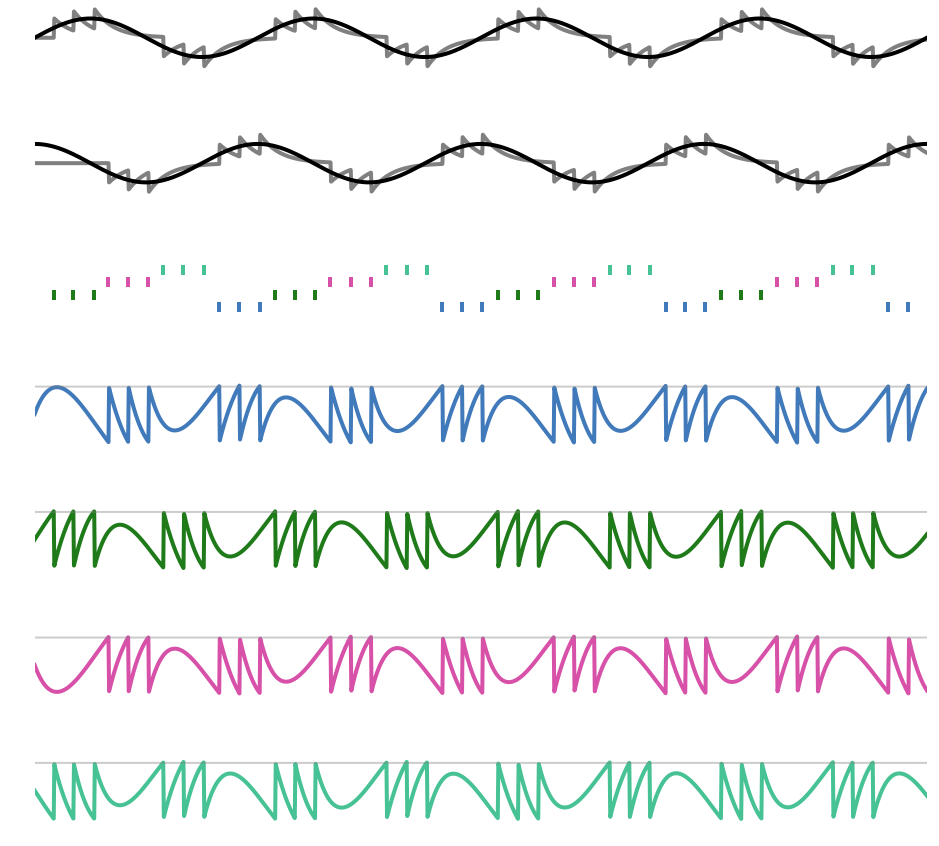

In [19]:
# Run simulation and plot results for given parameters
N = 4                                                    # number of neurons
d = 2                                                    # number of dimensions of input signal
dt = 0.03                                                # step size
iterations = 1500                                        # number of time steps
c_upp = [2, 2]                                           # input value
positive_signal = False                                  # allow negative or only positive input signal
constant= True                                           # create constant or time-variant input signal
sinusoidal = True                                        # create sinusoidal wafevorm as input signal
tau = 1                                                  # time constant
beta = 0.0                                               # cost 
color = np.random.randint(0, 255, size=(N, 3))/255       # color map for plotting the different neurons
plot_c = True                                            # plot the input + input der (=c) or only input signal
plot_voltage= True                                       # plot the voltages

# run simulation
D = initialize_weights(N, d)                                                                         # initialize decoding weights
t, voltage, x_est, o, T = initialize_params(N=N, d=d, dt=dt, iterations=iterations, D=D, beta=beta)  # initialize parameters
if sinusoidal == True:                                                                               # create d-dimensional input signal
    x, c = time_varying_signal(d, positive_signal=positive_signal)          
else:
    x, c = time_varying_signal_plateau(c_upp, constant=constant)     
run(tau, beta)                                                                                       # run simulation
visualize(color, plot_voltage=plot_voltage, plot_c=plot_c)                                           # plot results

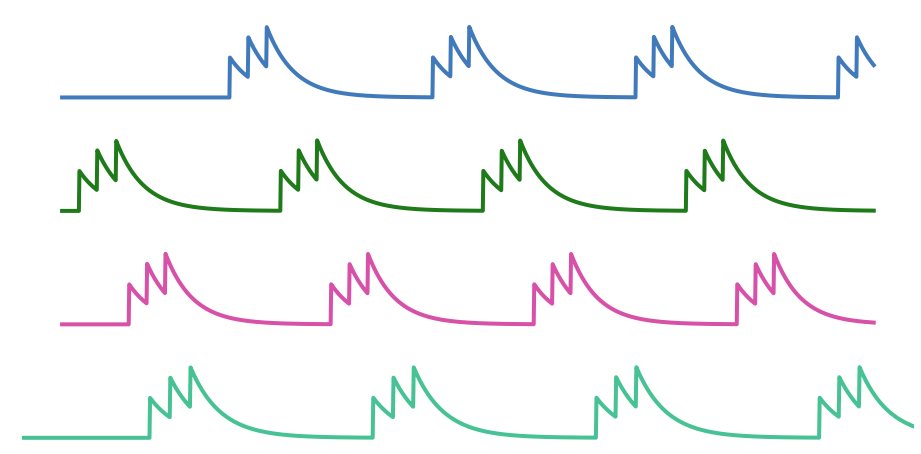

In [20]:
visualize_firing_rate(tau)

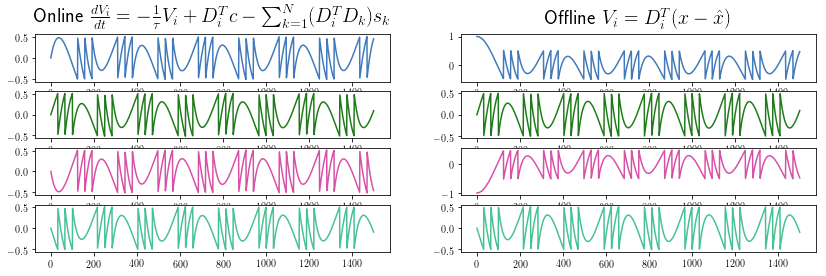

In [21]:
voltage_offline = visualize_voltage()

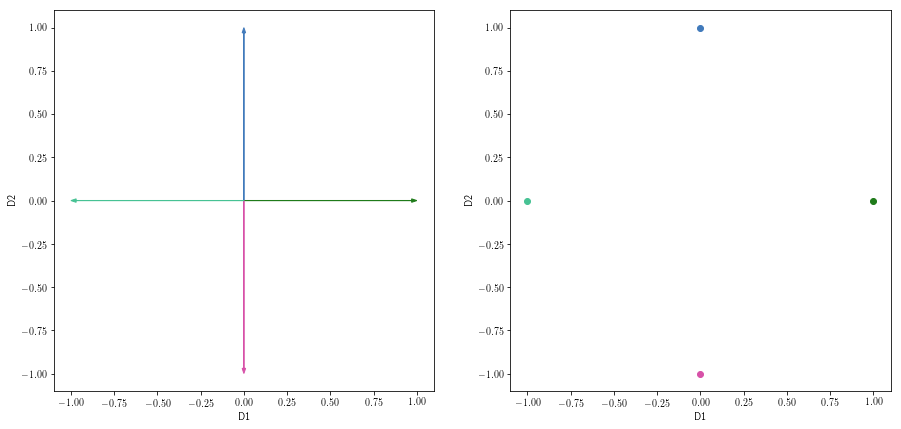

In [22]:
plot_weights()

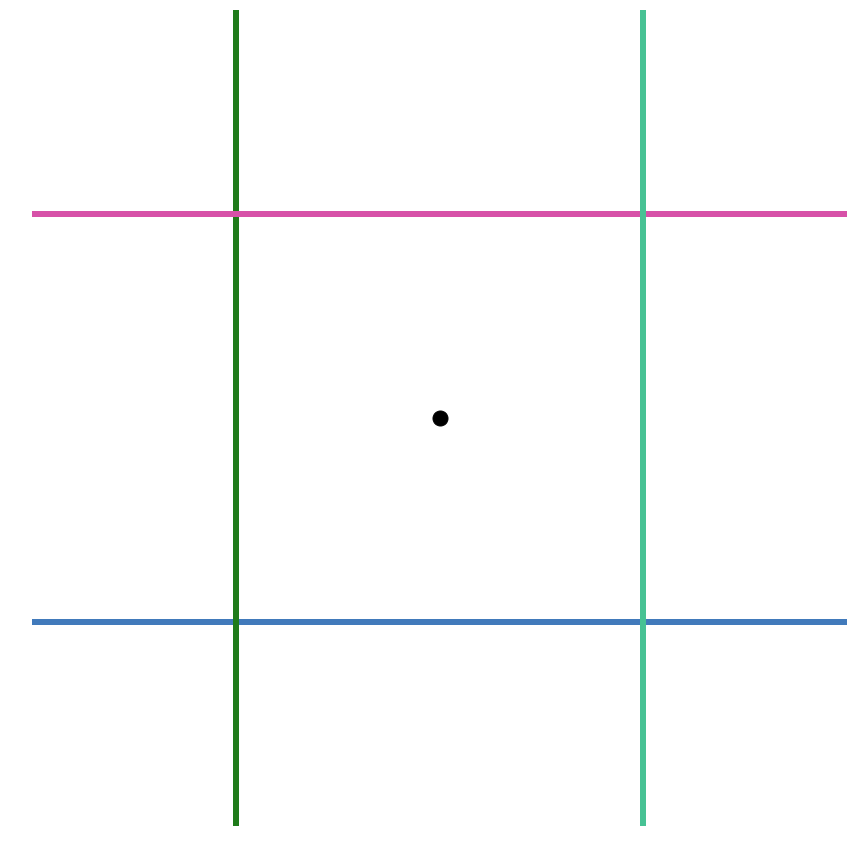

In [78]:
plot_error_space(plot_error=True, plot_true_signal=True, start=200)

MovieWriter imagemagick unavailable. Trying to use pillow instead.


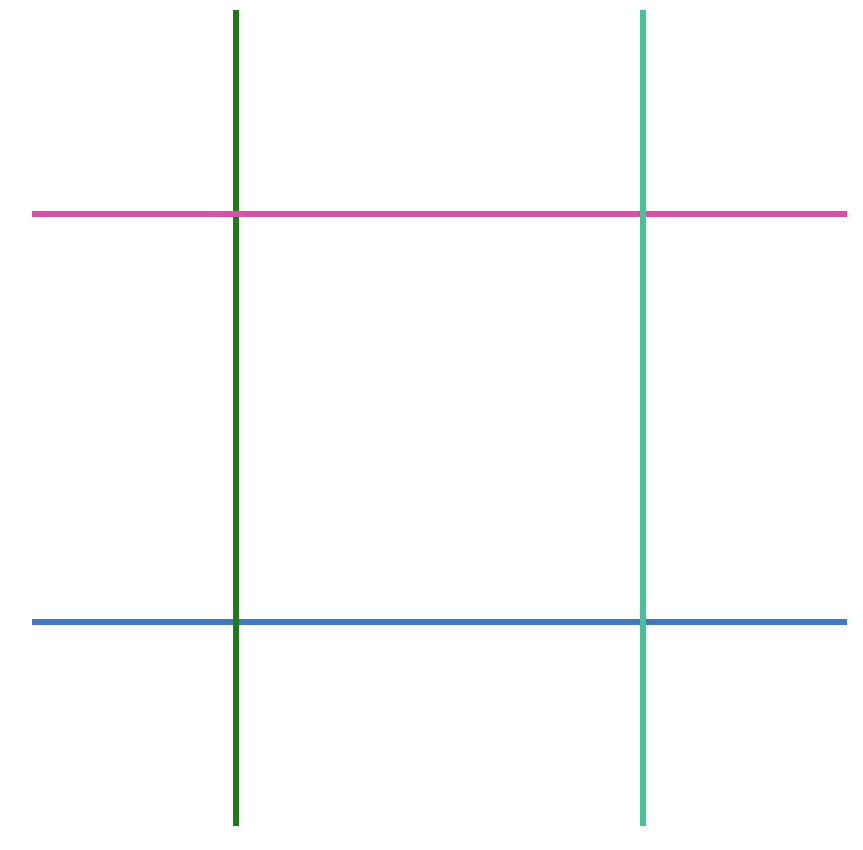

In [79]:
fig = bounding_box_animation_2D(iterations)